In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import os
import matplotlib.pyplot as plt
from glob import glob
import torch
from sklearn.metrics import roc_auc_score
import time
import math

In [2]:
train_df = pd.read_csv("../input/g2net-gravitational-wave-detection/training_labels.csv")
train_df

,id,target
0,00000e74ad,1
1,00001f4945,0
2,0000661522,0
3,00007a006a,0
4,0000a38978,1
...,...,...
559995,ffff9a5645,1
559996,ffffab0c27,0
559997,ffffcf161a,1
559998,ffffd2c403,0


In [3]:
paths = ["../input/g2net-gravitational-wave-detection/train/" + "/".join(id[:3]) + "/" + id + ".npy" for id in train_df.id.values]
train_df['path'] = paths
train_df

,id,target,path
0,00000e74ad,1,../input/g2net-gravitational-wave-detection/tr...
1,00001f4945,0,../input/g2net-gravitational-wave-detection/tr...
2,0000661522,0,../input/g2net-gravitational-wave-detection/tr...
3,00007a006a,0,../input/g2net-gravitational-wave-detection/tr...
4,0000a38978,1,../input/g2net-gravitational-wave-detection/tr...
...,...,...,...
559995,ffff9a5645,1,../input/g2net-gravitational-wave-detection/tr...
559996,ffffab0c27,0,../input/g2net-gravitational-wave-detection/tr...
559997,ffffcf161a,1,../input/g2net-gravitational-wave-detection/tr...
559998,ffffd2c403,0,../input/g2net-gravitational-wave-detection/tr...


In [4]:
def whiten(x):
    for i in range(3):
        spec = np.fft.rfft(x[i])
        mag = np.sqrt(np.real(spec*np.conj(spec)))
        norm = np.sqrt(np.array([4096/2]))
        x[i] = np.fft.irfft(spec/mag) * norm
    return x

In [5]:
def apply_bandpass(x, lf=30, hf=500, order=8, sr=2048):
    sos = signal.butter(order, [lf, hf], btype="bandpass", output="sos", fs=sr)
    normalization = np.sqrt((hf - lf) / (sr / 2))
    for i in range(3):
        x[i] = signal.sosfiltfilt(sos, x[i]) / normalization
    return x

In [6]:
def preprocess(x):
    x = x / np.max(np.abs(x), axis=-1, keepdims=True)
    #scale = np.array([[1.5e-20], [1.5e-20], [0.5e-20]])
    #x = x / scale
    x *= signal.tukey(4096, 0.1)
    #x = whiten(x)
    x = apply_bandpass(x)
    return x

In [7]:
class DataSet:
    def __init__(self, paths, target, index):
        self.paths = [paths[i] for i in index]
        self.target = [target[i] for i in index]
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        x = np.load(self.paths[index])
        x = preprocess(x)
        return x.astype(np.float32), self.target[index].astype(np.float32)

In [8]:
class SelfAttention(torch.nn.Module):
    def __init__(self, dim, out_dim):
        super(SelfAttention,self).__init__()
        self.dim = out_dim
        self.qkv_weight = torch.nn.Linear(dim, out_dim*3, bias=False)
    
    def forward(self, x):
        q, k, v = self.qkv_weight(x).chunk(3, dim=-1)
        att_logit = torch.bmm(q, k.transpose(1,2)) * (self.dim ** -0.5) # q * k
        att_weight = torch.softmax(att_logit, dim=-1)
        weighted_v = torch.bmm(att_weight, v) # q*k@k*dim == q * dim
        return weighted_v

In [9]:
class MultiheadSelfAttention(torch.nn.Module):
    def __init__(self, in_dim, out_dim, heads):
        super(MultiheadSelfAttention,self).__init__()
        head_out = out_dim // heads
        self.heads = torch.nn.ModuleList([SelfAttention(in_dim, head_out) for _ in range(heads)])
        self.output = torch.nn.Linear(out_dim, out_dim)
    def forward(self, x):
        outs = []
        for head in self.heads:
            out = head(x)
            outs.append(out)
        outs = torch.cat(outs, dim=-1)
        outs = self.output(outs)
        return outs

In [10]:
class Residual(torch.nn.Module):
    def __init__(self, fn, dim):
        super(Residual,self).__init__()
        self.fn = fn
        self.dropout = torch.nn.Dropout(p=0.2)
    def forward(self, x):
        hop = self.dropout(self.fn(x))
        y = x + hop
        return y

In [11]:
class Feedforward(torch.nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super(Feedforward,self).__init__()
        self.hidden = torch.nn.Sequential(torch.nn.Linear(embed_dim, hidden_dim),
                                        torch.nn.GELU(),
                                         torch.nn.Linear(hidden_dim, embed_dim))
    def forward(self, x):
        return self.hidden(x)

In [12]:
class Encoder(torch.nn.Module):
    def __init__(self, in_dim, embed_dim, hidden_dim, heads, depth):
        super(Encoder,self).__init__()
        self.feedforwards = torch.nn.ModuleList([Residual(Feedforward(embed_dim, hidden_dim), embed_dim) for _ in range(depth)])
        self.attentions = torch.nn.ModuleList([Residual(MultiheadSelfAttention(in_dim, embed_dim, heads), in_dim) if i == 0 
                                               else Residual(MultiheadSelfAttention(embed_dim, embed_dim, heads), embed_dim)
                                               for i in range(depth)])
    
    def forward(self, x):
        for ffn, attn in zip(self.feedforwards, self.attentions):
            x = attn(x)
            x = ffn(x)
        return x

In [13]:
class Recognizer(torch.nn.Module):
    def __init__(self, embed_dim):
        super(Recognizer,self).__init__()
        self.logit = torch.nn.Linear(embed_dim, 1)
        self.out = torch.nn.Sigmoid()
    def forward(self, x):
        x = self.logit(x).transpose(1, 2)
        x = x.reshape(x.shape[0], 3, -1)
        x = torch.max(x, dim=-1)[0].mean(dim=-1)
        out = self.out(x)
        return out, x

In [14]:
class CNN1d(torch.nn.Module):
    def __init__(self, embed_dim):
        super(CNN1d, self).__init__()
        self.CE = torch.nn.Sequential(torch.nn.BatchNorm1d(1),
                                    torch.nn.Conv1d(1, embed_dim//4, 16, stride=1, padding=0),
                                    torch.nn.GELU(),
                                    torch.nn.MaxPool1d(4, stride=4, padding=0),
                                    torch.nn.BatchNorm1d(embed_dim//4),
                                    torch.nn.Conv1d(embed_dim//4, embed_dim//2, 8, stride=1, padding=0),
                                    torch.nn.GELU(),
                                    torch.nn.MaxPool1d(4, stride=4, padding=0),
                                    torch.nn.BatchNorm1d(embed_dim//2),
                                    torch.nn.Conv1d(embed_dim//2, embed_dim, 8, stride=1, padding=0),
                                    torch.nn.GELU(),
                                    torch.nn.MaxPool1d(4, stride=4, padding=0))
        self.length = 61
    def forward(self, x):
        return self.CE(x)

In [15]:
class Embed(torch.nn.Module):
    def __init__(self, enc_dim, pe_dim, embed_dim, pe='fix'):
        super(Embed, self).__init__()
        dim = enc_dim
        self.CNN = CNN1d(dim)
        max_len = self.CNN.length
        if pe == 'fix':
            position = torch.arange(max_len).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, pe_dim, 2) * (-math.log(10000.0) / pe_dim))
            pe = torch.zeros(max_len, pe_dim)
            pe[:, 0::2] = torch.sin(position * div_term)
            pe[:, 1::2] = torch.cos(position * div_term)
            pe = pe.repeat((3,1))
            detector = torch.zeros(max_len*3, 3)
            detector[:max_len, 0] = 1
            detector[max_len:max_len*2, 1] = 1
            detector[max_len*2:max_len*3, 2] = 1
            self.pe = torch.cat([pe, detector], dim=-1)
            out_dim = dim + pe_dim + 3
        elif pe == 'trainable':
            self.tpe = torch.nn.Parameter(torch.randn(max_len, pe_dim))
            detector = torch.zeros(max_len*3, 3)
            detector[:max_len, 0] = 1
            detector[max_len:max_len*2, 1] = 1
            detector[max_len*2:max_len*3, 2] = 1
            self.pe = torch.cat([self.tpe.repeat((3,1)), detector], dim=-1)
            out_dim = dim + pe_dim + 3
        else:
            self.pe = None
            out_dim = dim
        
        self.embed = torch.nn.Linear(out_dim, embed_dim, bias=False)

    def forward(self, x):
        ss = []
        for i in range(x.shape[1]):
            s = x[:,i,:].unsqueeze(1)
            fts = self.CNN(s).transpose(1, 2)
            std, mean = torch.std_mean(fts, dim=(1,2), unbiased=False, keepdim=True)
            fts = torch.div(fts-mean, std)
            ss.append(fts)
        x = torch.cat(ss, dim=1)
        if self.pe is not None:
            x = torch.cat([x, self.pe.to(x.device).repeat((x.shape[0],1,1))], dim=-1)
        x = self.embed(x)
        return x

In [16]:
class Model(torch.nn.Module):
    def __init__(self, enc_dim, pe_dim, embed_dim, hidden_dim, heads, depth, pe='fix'):
        super(Model,self).__init__()
        self.embed = Embed(enc_dim, pe_dim, embed_dim, pe=pe)
        self.encoder = Encoder(embed_dim, embed_dim, hidden_dim, heads, depth)
        self.recognizer = Recognizer(embed_dim)
    
    def forward(self, x):
        x = self.embed(x)
        x = self.encoder(x)
        out, x = self.recognizer(x)
        return out, x

In [17]:
seed = 2434
pe_dim = 128
enc_dim = 128
embed_dim = 256
hidden_dim = 256*4
heads = 4
depth = 4
pe = 'fix'
lr = 1e-4
weight_decay = 1e-5
train_batch_size = 256
test_batch_size = 512
optimizer = 'Adam'
grad_clip = 1000

In [18]:
np.random.seed(seed)
torch.manual_seed(seed)
train_index = np.random.rand(train_df.shape[0]) < 0.9
val_index = ~train_index
train_index = np.nonzero(train_index)[0]
val_index = np.nonzero(val_index)[0]
train_dataset = DataSet(train_df.path.values, train_df.target.values, train_index)
val_dataset = DataSet(train_df.path.values, train_df.target.values, val_index)

In [19]:
epochs = 10
device = 'cuda'
num_worker = os.cpu_count()
model = Model(enc_dim, pe_dim, embed_dim, hidden_dim, heads, depth, pe).to(device)
best_model = Model(enc_dim, pe_dim, embed_dim, hidden_dim, heads, depth, pe).to(device)
best_model.load_state_dict(model.state_dict())
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size,
                                         shuffle=True, drop_last=True, num_workers=num_worker, pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=test_batch_size,
                                         shuffle=False, drop_last=False, num_workers=num_worker, pin_memory=True)
start_time = time.time()
train_loss_list = []
train_auc_list = []
val_loss_list = []
val_auc_list = []
best_auc = 0
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_auc = 0
    count = 0
    batch_count = 0
    preds = []
    targets = []
    for data, target in train_dataloader:
        optim.zero_grad()
        data = data.to(device)
        target = target.to(device)
        pred, x = model(data)
        loss = criterion(x, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optim.step()
        train_loss += loss.item()
        preds.append(pred.detach().cpu().numpy())
        targets.append(target.cpu().numpy())
        count += data.shape[0]
        batch_count += 1
    train_loss = train_loss / count
    preds = np.concatenate(preds, axis=0)
    targets = np.concatenate(targets, axis=0)
    train_auc = roc_auc_score(targets, preds)
    train_loss_list.append(train_loss)
    train_auc_list.append(train_auc)
    
    model.eval()
    with torch.no_grad():
        val_loss = 0
        val_auc = 0
        count = 0
        batch_count = 0
        preds = []
        targets = []
        for data, target in val_dataloader:
            data = data.to(device)
            target = target.to(device)
            pred, x = model(data)
            loss = criterion(x, target)
            val_loss += loss.item()
            preds.append(pred.detach().cpu().numpy())
            targets.append(target.cpu().numpy())
            count += data.shape[0]
            batch_count += 1
        val_loss = val_loss / count
        preds = np.concatenate(preds, axis=0)
        targets = np.concatenate(targets, axis=0)
        val_auc = roc_auc_score(targets, preds)
        val_loss_list.append(val_loss)
        val_auc_list.append(val_auc)
    spent_time = time.time() - start_time
    print(f'epoch: {epoch} train loss: {train_loss} train auc: {train_auc} val loss: {val_loss} val auc: {val_auc} time: {spent_time/60} min')
    if val_auc >= best_auc:
        best_auc = val_auc
        best_model.load_state_dict(model.state_dict())
    if spent_time >= 25000:
        print('time over')
        break

epoch: 0 train loss: 0.47678901230156756 train auc: 0.8284693092169959 val loss: 0.5229373363191807 val auc: 0.836573975939286 time: 83.46436281998952 min
epoch: 1 train loss: 0.4457662624868419 train auc: 0.8496010127769736 val loss: 0.46763185749713926 val auc: 0.8483072303650009 time: 153.7411775827408 min
epoch: 2 train loss: 0.4360087947260613 train auc: 0.8554806587632069 val loss: 0.47349863372104234 val auc: 0.8385723382985322 time: 224.36621654431025 min
epoch: 3 train loss: 0.43010964636998833 train auc: 0.8588805229864567 val loss: 0.46900227988925136 val auc: 0.8459726520314239 time: 294.2271575331688 min
epoch: 4 train loss: 0.4244472940238131 train auc: 0.8623613603509005 val loss: 0.4626397798238831 val auc: 0.8504313746112059 time: 364.85483620564145 min
epoch: 5 train loss: 0.42012522771856153 train auc: 0.864750609327987 val loss: 0.46318844615136395 val auc: 0.8526569991131233 time: 436.29227875471116 min
time over


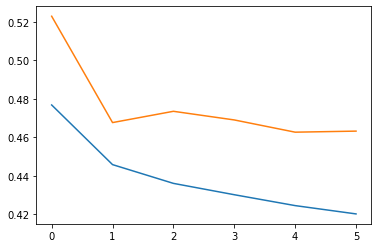

In [20]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)

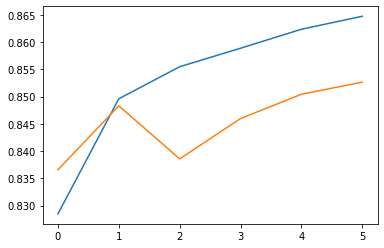

In [21]:
plt.plot(train_auc_list)
plt.plot(val_auc_list)

In [22]:
torch.save(model.state_dict(), "model")

In [23]:
paths = glob("../input/g2net-gravitational-wave-detection/test/*/*/*/*")
ids = [path.split("/")[-1].split(".")[0] for path in paths]
test_df = pd.DataFrame({"path":paths,"id":ids})
test_df['target'] = 0.0
test_df = test_df.set_index('id')
test_df = test_df.sort_index()
test_df

,path,target
id,,
00005bced6,../input/g2net-gravitational-wave-detection/te...,0.0
0000806717,../input/g2net-gravitational-wave-detection/te...,0.0
0000ef4fe1,../input/g2net-gravitational-wave-detection/te...,0.0
00020de251,../input/g2net-gravitational-wave-detection/te...,0.0
00024887b5,../input/g2net-gravitational-wave-detection/te...,0.0
...,...,...
ffff4125f1,../input/g2net-gravitational-wave-detection/te...,0.0
ffff9d32a6,../input/g2net-gravitational-wave-detection/te...,0.0
ffff9f4c1f,../input/g2net-gravitational-wave-detection/te...,0.0


In [24]:
class TestDataSet:
    def __init__(self, paths, ids):
        self.paths = paths
        self.ids = ids

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        x = np.load(self.paths[index])
        x = preprocess(x).astype(np.float32)
        return x, self.ids[index]

In [25]:
test_dataset = TestDataSet(test_df.path.values, test_df.index.values)

In [26]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=512,
                                         shuffle=False, drop_last=False, num_workers=num_worker, pin_memory=True)

In [27]:
best_model.eval()
with torch.no_grad():
    for data, ids in test_dataloader:
        data = data.to(device)
        pred, x = best_model(data)
        test_df.loc[list(ids),'target'] = pred.cpu().numpy()

In [28]:
test_df

,path,target
id,,
00005bced6,../input/g2net-gravitational-wave-detection/te...,1.000000
0000806717,../input/g2net-gravitational-wave-detection/te...,0.710024
0000ef4fe1,../input/g2net-gravitational-wave-detection/te...,0.456643
00020de251,../input/g2net-gravitational-wave-detection/te...,0.915793
00024887b5,../input/g2net-gravitational-wave-detection/te...,0.361522
...,...,...
ffff4125f1,../input/g2net-gravitational-wave-detection/te...,0.579821
ffff9d32a6,../input/g2net-gravitational-wave-detection/te...,0.512304
ffff9f4c1f,../input/g2net-gravitational-wave-detection/te...,0.319973


In [29]:
test_df.to_csv('submission.csv', columns=['target'])